In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from transformers import ElectraTokenizer, ElectraModel
from transformers import XLNetTokenizer
from transformers import XLNetModel
import torch
from transformers import RobertaTokenizer, RobertaModel
import torch.nn as nn
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split

from transformers import BertModel

import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim

import numpy as np

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())  # Should print True if CUDA is detected

print(torch.cuda.device_count())  # Should return the number of GPUs available

print(torch.cuda.get_device_name(0))  # Should print the name of the GPU (e.g., NVIDIA GeForce RTX 4060)


True
2
Tesla T4


In [3]:
# Load your dataset

data = pd.read_csv("/kaggle/input/cyberguard/Modified_Data.csv")



# Split into train and validation sets

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)



# Initialize the tokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# DATA PREPROCESSING

In [4]:
# Tokenize data

def tokenize_data(data):

    return tokenizer(

        data["crimeaditionalinfo"].tolist(),

        padding=True,

        truncation=True,

        max_length=128,

        return_tensors="pt"

    )



# Tokenize both train and validation data

train_encodings = tokenize_data(train_data)

val_encodings = tokenize_data(val_data)


In [5]:
# Convert labels to tensors

train_labels_category = torch.tensor(train_data["category"].values)

train_labels_sub_category = torch.tensor(train_data["sub_category"].values)



val_labels_category = torch.tensor(val_data["category"].values)

val_labels_sub_category = torch.tensor(val_data["sub_category"].values)

In [6]:
# Convert labels to long data type

train_labels_category = train_labels_category.long()

train_labels_sub_category = train_labels_sub_category.long()



val_labels_category = val_labels_category.long()

val_labels_sub_category = val_labels_sub_category.long()

In [7]:
# Create datasets and data loaders

train_dataset = TensorDataset(

    train_encodings['input_ids'], train_encodings['attention_mask'],

    train_labels_category, train_labels_sub_category

)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)



# Similar setup for the validation loader

val_dataset = TensorDataset(

    val_encodings['input_ids'], val_encodings['attention_mask'],

    val_labels_category, val_labels_sub_category

)

val_loader = DataLoader(val_dataset, batch_size=8)


# MODEL CREATION

In [8]:
class MultiTaskModel(nn.Module):

    def __init__(self, model_name, num_labels_task1, num_labels_task2):

        super(MultiTaskModel, self).__init__()

        self.bert = RobertaModel.from_pretrained(model_name)

        self.classifier_task1 = nn.Linear(self.bert.config.hidden_size, num_labels_task1)

        self.classifier_task2 = nn.Linear(self.bert.config.hidden_size, num_labels_task2)



    def forward(self, input_ids, attention_mask, labels_task1=None, labels_task2=None):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = outputs.pooler_output

        logits_task1 = self.classifier_task1(pooled_output)

        logits_task2 = self.classifier_task2(pooled_output)



        loss = None

        if labels_task1 is not None and labels_task2 is not None:

            loss_fn = nn.CrossEntropyLoss()

            loss_task1 = loss_fn(logits_task1, labels_task1)

            loss_task2 = loss_fn(logits_task2, labels_task2)

            loss = loss_task1 + loss_task2



        return {"loss": loss, "logits_task1": logits_task1, "logits_task2": logits_task2}

In [9]:
num_labels_task1 = 15

num_labels_task2 = 35



print(f"Unique classes in 'category': {num_labels_task1}")

print(f"Unique classes in 'sub_category': {num_labels_task2}")



# Initialize the model with dynamic class counts

model = MultiTaskModel("roberta-base", num_labels_task1=num_labels_task1, num_labels_task2=num_labels_task2)
model.to(device)

Unique classes in 'category': 15
Unique classes in 'sub_category': 35


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiTaskModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Lay

In [10]:
# Create data loaders

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],

                              train_labels_category, train_labels_sub_category)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)



# Optimizer

optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [11]:
# Initialize lists to store metrics

train_accuracies_task1 = []

train_accuracies_task2 = []

val_accuracies_task1 = []

val_accuracies_task2 = []

# TRAINING LOOP

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to track metrics across epochs
train_accuracies_task1, train_accuracies_task2 = [], []
val_accuracies_task1, val_accuracies_task2 = [], []
train_precisions_task1, train_precisions_task2 = [], []
val_precisions_task1, val_precisions_task2 = [], []
train_recalls_task1, train_recalls_task2 = [], []
val_recalls_task1, val_recalls_task2 = [], []
train_f1s_task1, train_f1s_task2 = [], []
val_f1s_task1, val_f1s_task2 = [], []
val_roc_aucs_task1, val_roc_aucs_task2 = [], []
final_val_preds_task1, final_val_preds_task2 = [], []
final_val_labels_task1, final_val_labels_task2 = [], []
for epoch in range(3):
    model.train()
    total_train_loss = 0

    # Initialize lists to track predictions and labels for each task
    train_preds_task1, train_preds_task2 = [], []
    train_labels_task1, train_labels_task2 = [], []

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels_task1 = batch[2].to(device)
        labels_task2 = batch[3].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels_task1=labels_task1, labels_task2=labels_task2)
        loss = outputs["loss"]
        total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Collect predictions and labels for accuracy calculations
        train_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())
        train_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())
        train_labels_task1.extend(labels_task1.cpu().numpy())
        train_labels_task2.extend(labels_task2.cpu().numpy())

    # Training metrics for Task 1
    train_accuracy_task1 = accuracy_score(train_labels_task1, train_preds_task1)
    precision_task1, recall_task1, f1_task1, _ = precision_recall_fscore_support(train_labels_task1, train_preds_task1, average="weighted")
    train_accuracies_task1.append(train_accuracy_task1)
    train_precisions_task1.append(precision_task1)
    train_recalls_task1.append(recall_task1)
    train_f1s_task1.append(f1_task1)

    # Training metrics for Task 2
    train_accuracy_task2 = accuracy_score(train_labels_task2, train_preds_task2)
    precision_task2, recall_task2, f1_task2, _ = precision_recall_fscore_support(train_labels_task2, train_preds_task2, average="weighted")
    train_accuracies_task2.append(train_accuracy_task2)
    train_precisions_task2.append(precision_task2)
    train_recalls_task2.append(recall_task2)
    train_f1s_task2.append(f1_task2)

    # Validation phase
    model.eval()
    val_preds_task1, val_preds_task2 = [], []
    val_labels_task1, val_labels_task2 = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels_task1 = batch[2].to(device)
            labels_task2 = batch[3].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Collect predictions and labels
            val_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())
            val_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())
            val_labels_task1.extend(labels_task1.cpu().numpy())
            val_labels_task2.extend(labels_task2.cpu().numpy())

    # Save final predictions and labels for confusion matrix plotting
    if epoch == 2:  # if it's the last epoch, save these
        final_val_preds_task1 = val_preds_task1
        final_val_preds_task2 = val_preds_task2
        final_val_labels_task1 = val_labels_task1
        final_val_labels_task2 = val_labels_task2

    # Validation metrics for Task 1
    val_accuracy_task1 = accuracy_score(val_labels_task1, val_preds_task1)
    precision_task1, recall_task1, f1_task1, _ = precision_recall_fscore_support(val_labels_task1, val_preds_task1, average="weighted")
    val_accuracies_task1.append(val_accuracy_task1)
    val_precisions_task1.append(precision_task1)
    val_recalls_task1.append(recall_task1)
    val_f1s_task1.append(f1_task1)

    # ROC AUC (only if at least two classes exist in the validation set)
    try:
        val_roc_auc_task1 = roc_auc_score(val_labels_task1, outputs["logits_task1"].cpu(), multi_class="ovr")
        val_roc_aucs_task1.append(val_roc_auc_task1)
    except ValueError:
        val_roc_auc_task1 = None

    # Validation metrics for Task 2
    val_accuracy_task2 = accuracy_score(val_labels_task2, val_preds_task2)
    precision_task2, recall_task2, f1_task2, _ = precision_recall_fscore_support(val_labels_task2, val_preds_task2, average="weighted")
    val_accuracies_task2.append(val_accuracy_task2)
    val_precisions_task2.append(precision_task2)
    val_recalls_task2.append(recall_task2)
    val_f1s_task2.append(f1_task2)

    # ROC AUC for Task 2
    try:
        val_roc_auc_task2 = roc_auc_score(val_labels_task2, outputs["logits_task2"].cpu(), multi_class="ovr")
        val_roc_aucs_task2.append(val_roc_auc_task2)
    except ValueError:
        val_roc_auc_task2 = None

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

# VISUALIZATION

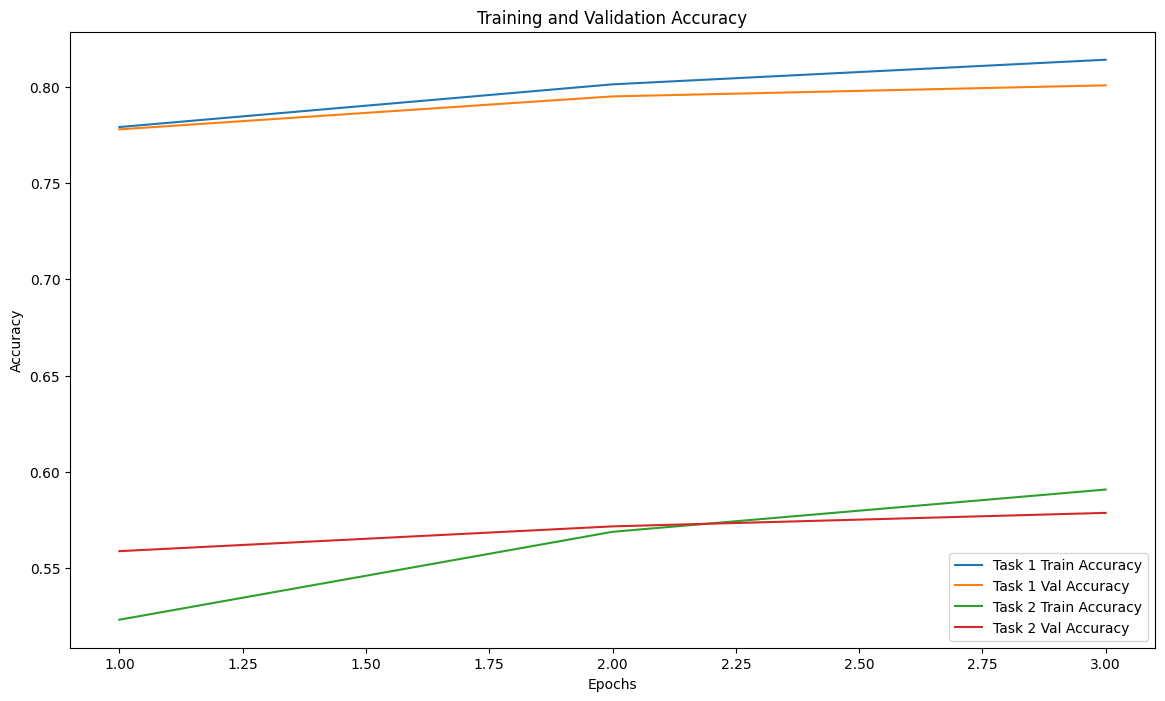

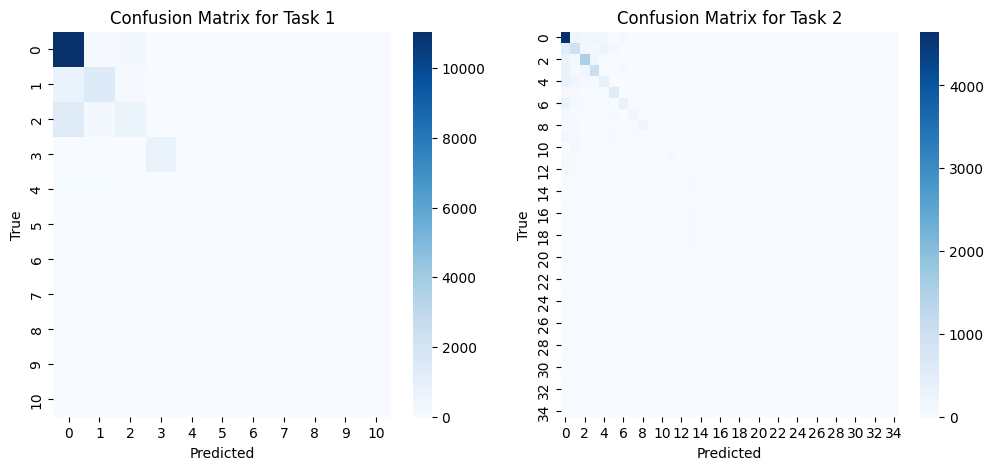

In [13]:
epochs = range(1, 4)

plt.figure(figsize=(14, 8))
plt.plot(epochs, train_accuracies_task1, label="Task 1 Train Accuracy")
plt.plot(epochs, val_accuracies_task1, label="Task 1 Val Accuracy")
plt.plot(epochs, train_accuracies_task2, label="Task 2 Train Accuracy")
plt.plot(epochs, val_accuracies_task2, label="Task 2 Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Plot confusion matrices for Task 1 and Task 2
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_task1 = confusion_matrix(final_val_labels_task1, final_val_preds_task1)
sns.heatmap(cm_task1, annot=False, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Confusion Matrix for Task 1")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

cm_task2 = confusion_matrix(final_val_labels_task2, final_val_preds_task2)
sns.heatmap(cm_task2, annot=False, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix for Task 2")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.show()